# Trading Strategy (Unsupervised Learning)

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [2]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095448   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956310   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZION      1420600.0  
           ZTS       1007200.0  

[994508 rows x 6 columns]

## Calculating features and technical indicators for each stock

In [3]:
# Garman-Klass Volatility, RSI, Bollinger Bands, ATR, MACD, Dollar Volume

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.134430   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095448   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.977474   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.778069   57.610001   58.320000   56.400002   58.060001   
           ABT      36.956310   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 YUM     130.660004  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.699997  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZION     43.869999   43.869999   44.650002   43.720001   44.650002   
           ZTS     197.369995  197.369995  198.009995  196.250000  196.679993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-04 A         3287300.0         -0.001893        NaN       NaN   
           AAL      12037200.0         -0.000821        NaN       NaN   
           AAPL    270597600.0         -0.001233        NaN       NaN   
           ABBV     10308400.0         -0.047666        NaN       NaN   
           ABT      12227500.0         -0.010932        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-29 YUM       1196800.0          0.000030  59.338371  4.824633   
           ZBH        849600.0          0.000044  68.767246  4.753563   
           ZBRA       251300.0          0.000073  67.914673  5.415905   
           ZION      1420600.0          0.000102  62.879829  3.611585   
           ZTS       1007200.0          0.000035  66.791335  5.186448   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-04 A            NaN       NaN       NaN       NaN     125.359312  
           AAL          NaN       NaN       NaN       NaN     470.599721  
           AAPL         NaN       NaN       NaN       NaN    6488.246976  
           ABBV         NaN       NaN       NaN       NaN     420.356642  
           ABT          NaN       NaN       NaN       NaN     451.883284  
...                     ...       ...       ...       ...            ...  
2023-12-29 YUM     4.862793  4.900952 -0.073239  0.784240     156.373892  
           ZBH     4.784470  4.815377 -1.054422  0.973531     103.396317  
           ZBRA    5.546306  5.676707 -0.154931  1.577769      68.687826  
           ZION    3.749483  3.887381  0.177122  2.099563      62.321720  
           ZTS     5.259449  5.332449  0.420520  2.164720     198.791059  

[994508 rows x 14 columns]

<Axes: xlabel='date'>

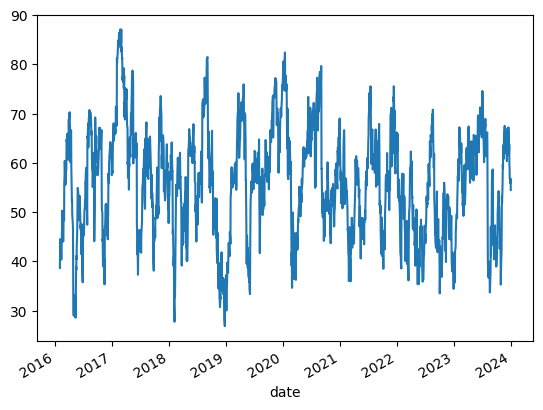

In [4]:
df.xs('AAPL', level = 1)['rsi'].plot()

## Filtering top 150 most liquid stocks for each month

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A           91.918048   35.004200 -0.932886  3.620122  3.522492   
           AAL        338.977811   39.288383  0.977081  3.729458  3.547833   
           AAPL      3548.073804   22.125887 -1.017466  3.155194  3.106253   
           ABBV       357.006451   39.060574 -0.477602  3.734669  3.638599   
           ABT        245.865726   33.559795 -0.797320  3.570935  3.483742   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        207.539266  130.660004 -0.073239  4.900952  4.824633   
           ZBH        207.682671  121.699997 -1.054422  4.815377  4.753563   
           ZBRA        98.037275  273.329987 -0.154931  5.676707  5.415905   
           ZION       102.724363   43.869999  0.177122  3.887381  3.611585   
           ZTS        335.154638  197.369995  0.420520  5.332449  5.186448   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-02-29 A       3.571307         -0.001914 -0.240044  48.107904  
           AAL     3.638645         -0.000319  0.529241  56.664392  
           AAPL    3.130723         -0.003013 -0.330066  48.335957  
           ABBV    3.686634         -0.049102 -0.288564  47.896405  
           ABT     3.527338         -0.009363 -0.394515  47.034954  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.862793          0.000030  0.784240  59.338371  
           ZBH     4.784470          0.000044  0.973531  68.767246  
           ZBRA    5.546306          0.000073  1.577769  67.914673  
           ZION    3.749483          0.000102  2.099563  62.879829  
           ZTS     5.259449          0.000035  2.164720  66.791335  

[46953 rows x 9 columns]

In [6]:
# 5 Year rolling average of dollar volume for each stocks before filtering
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-01-31 AAL      42.760246  1.295678  3.891346  3.789144  3.840245   
           AAPL     28.233545 -1.191554  3.389455  3.332440  3.360948   
           ABBV     45.380966 -1.207862  3.877334  3.814875  3.846105   
           ABT      37.100910 -1.167994  3.643741  3.577130  3.610435   
           ACN     102.222717 -1.021878  4.667883  4.637933  4.652908   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.700001 -1.182997  3.681654  3.632663  3.657159   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-01-31 AAL            -0.000522 -0.163933  42.277618  
           AAPL           -0.001885 -0.108144  67.547539  
           ABBV           -0.029823 -0.322388  49.245563  
           ABT            -0.002947  0.206063  66.810992  
           ACN            -0.004494 -0.450311  41.080233  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000028  3.205584  65.899356  
           VZ              0.000041  0.466400  57.985190  
           WFC             0.000025  1.913446  67.347850  
           WMT             0.000017 -0.274379  52.372668  
           XOM             0.000041 -0.683288  42.607132  

[12516 rows x 8 columns]

In [7]:
# Monthly Returns for different time horizons as features
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943867  1.275944  4.089372  3.908840  3.999106   
           AAPL     39.581043 -0.960483  3.781592  3.700759  3.741176   
           ABBV     86.127296  1.476496  4.536019  4.272025  4.404022   
           ABT      56.398468 -0.696011  4.073903  3.956251  4.015077   
           ACN     147.171127 -0.984613  5.015498  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    406.890015  1.086119  6.088512  5.817492  5.953002   
           VZ       37.700001 -1.182997  3.681654  3.632663  3.657159   
           WFC      49.220001 -0.753985  3.975643  3.800094  3.887869   
           WMT     157.649994 -0.005190  5.072549  5.018094  5.045321   
           XOM      99.980003  0.072672  4.651270  4.594084  4.622677   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.617049  53.332160   0.044013   
           AAPL           -0.001000 -0.414727  40.100669  -0.010636   
           ABBV           -0.033621  2.091142  62.305773   0.168700   
           ABT            -0.004175  0.975507  69.274931   0.094397   
           ACN            -0.002706  0.293259  63.135403   0.049709   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000028  3.205584  65.899356   0.146783   
           VZ              0.000041  0.466400  57.985190  -0.016436   
           WFC             0.000025  1.913446  67.347850   0.103835   
           WMT             0.000017 -0.274379  52.372668   0.016350   
           XOM             0.000041 -0.683288  42.607132  -0.026864   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079893   0.077893   0.081693   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041095    0.035516  
           ACN      0.041987   0.041220   0.039210   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.060030   0.053758   0.024490   0.028824    0.028985  
           VZ       0.035933   0.055029   0.008786   0.002693    0.002233  
           WFC      0.117430   0.067168   0.026895   0.033852    0.017357  
           WMT     -0.015960  -0.003544   0.001708   0.008697    0.010148  
           XOM     -0.023690  -0.049736  -0.008782  -0.007363   -0.005374  

[10344 rows x 14 columns]

## Fama-French Factors and Calculate Rolling Factor Betas

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10198 rows x 6 columns]

In [9]:
# Filtering out stocks with less than 10 months of data
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049709
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10147 rows x 6 columns]

In [10]:
# Calculating Rolling Factor Betas
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376280 -0.326575 -0.445064  0.318978  0.869254
           VZ      0.444391 -0.662955  0.517151  0.210200 -0.205922
           WFC     1.037897  0.401001  2.011854 -0.363960 -1.477539
           WMT     0.497262  0.081988 -0.731000  0.577487  0.752985
           XOM     0.722589 -0.210771  1.202658  0.229340  0.172208

[10147 rows x 5 columns]

In [11]:
# Joining the Rolling Factors data to the main dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10147 entries, (Timestamp('2018-01-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10147 non-null  float64
 1   bb_high           10147 non-null  float64
 2   bb_low            10147 non-null  float64
 3   bb_mid            10147 non-null  float64
 4   garman_klass_vol  10147 non-null  float64
 5   macd              10147 non-null  float64
 6   rsi               10147 non-null  float64
 7   return_1m         10147 non-null  float64
 8   return_2m         10147 non-null  float64
 9   return_3m         10147 non-null  float64
 10  return_6m         10147 non-null  float64
 11  return_9m         10147 non-null  float64
 12  return_12m        10147 non-null  float64
 13  Mkt-RF            10147 non-null  float64
 14  SMB               10147 non-null  floa

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

In [13]:
# Applying pre-defined centroids
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [14]:
# K-Means Clustering Algorithm (Months) to group similar assets based on their features
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-01-31 AAL     1.275944  4.089372  3.908840  3.999106          0.000502   
           AAPL   -0.960483  3.781592  3.700759  3.741176         -0.001000   
           ABBV    1.476496  4.536019  4.272025  4.404022         -0.033621   
           ABT    -0.696011  4.073903  3.956251  4.015077         -0.004175   
           ACN    -0.984613  5.015498  4.968583  4.992040         -0.002706   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    1.086119  6.088512  5.817492  5.953002          0.000028   
           VZ     -1.182997  3.681654  3.632663  3.657159          0.000041   
           WFC    -0.753985  3.975643  3.800094  3.887869          0.000025   
           WMT    -0.005190  5.072549  5.018094  5.045321          0.000017   
           XOM     0.072672  4.651270  4.594084  4.622677          0.000041   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 AAL     0.617049  53.332160   0.044013   0.037235   0.051541   
           AAPL   -0.414727  40.100669  -0.010636  -0.012944  -0.001992   
           ABBV    2.091142  62.305773   0.168700   0.079893   0.077893   
           ABT     0.975507  69.274931   0.094397   0.052610   0.048209   
           ACN     0.293259  63.135403   0.049709   0.041987   0.041220   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    3.205584  65.899356   0.146783   0.060030   0.053758   
           VZ      0.466400  57.985190  -0.016436   0.035933   0.055029   
           WFC     1.913446  67.347850   0.103835   0.117430   0.067168   
           WMT    -0.274379  52.372668   0.016350  -0.015960  -0.003544   
           XOM    -0.683288  42.607132  -0.026864  -0.023690  -0.049736   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249866  1.364708   
           AAPL     0.021212   0.018481    0.028553  1.309647 -0.322089   
           ABBV     0.081693   0.063580    0.054846  0.471598  0.471137   
           ABT      0.041483   0.041095    0.035516  0.817002 -0.161576   
           ACN      0.039210   0.032852    0.030836  1.214378 -0.164182   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.024490   0.028824    0.028985  0.525011  0.001544   
           VZ       0.008786   0.002693    0.002233  0.488887 -0.360819   
           WFC      0.026895   0.033852    0.017357  1.076098 -0.094079   
           WMT      0.001708   0.008697    0.010148  0.610658 -0.446030   
           XOM     -0.008782  -0.007363   -0.005374  1.138796  0.273602   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.550424  0.308895  0.674377        1  
           AAPL   -0.616277  0.569703  0.568892        0  
           ABBV   -0.092799  0.370264  0.262703        2  
           ABT    -0.518632  0.287618  0.988571        3  
           ACN    -0.309567  0.294670  0.177457        2  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.906215  0.132005  0.860918        0  
           VZ      0.085436  0.292000  0.474501        2  
           WFC     1.438222 -0.732210 -0.616143        0  
           WMT    -0.313553  0.315893  0.700381        2  
           XOM     0.675688 -0.489313  0.647679        1  

[10147 rows x 19 columns]

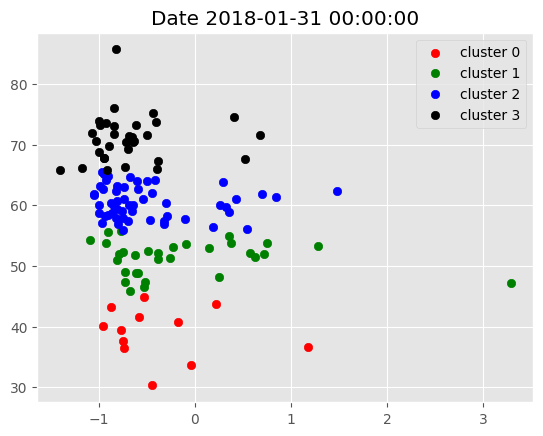

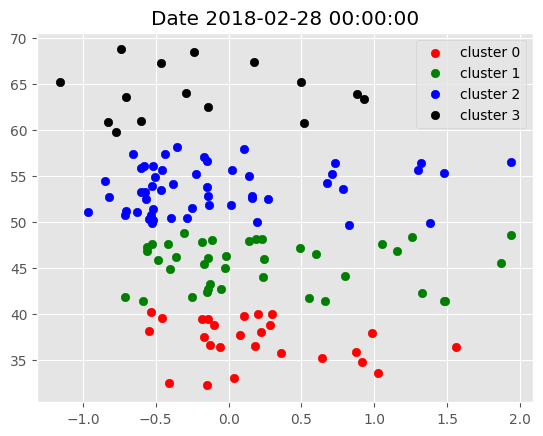

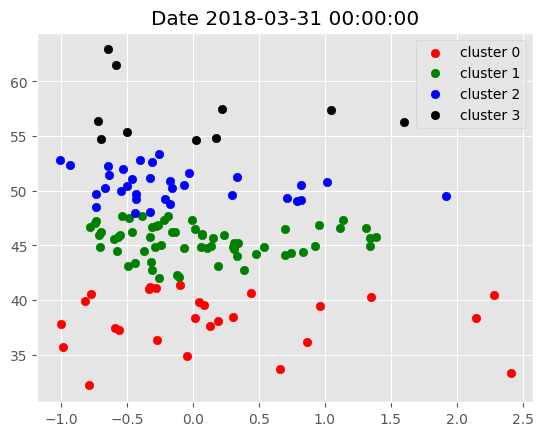

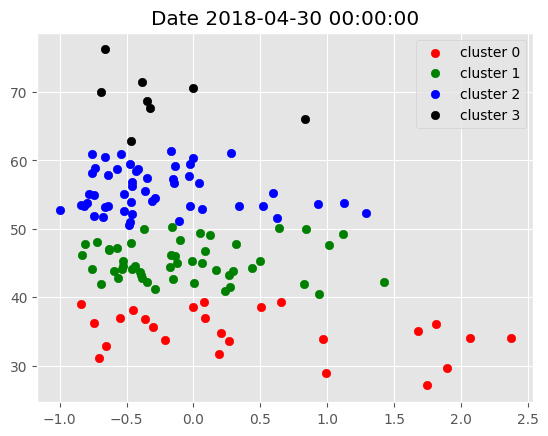

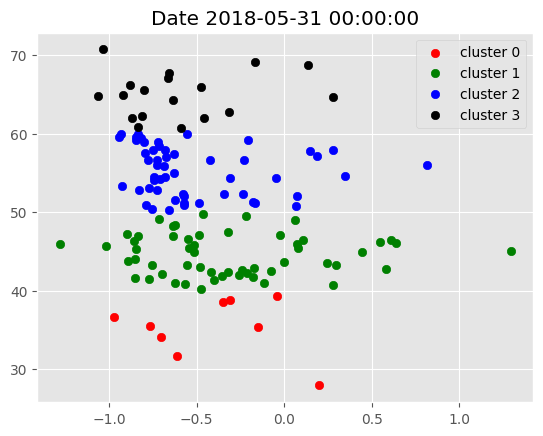

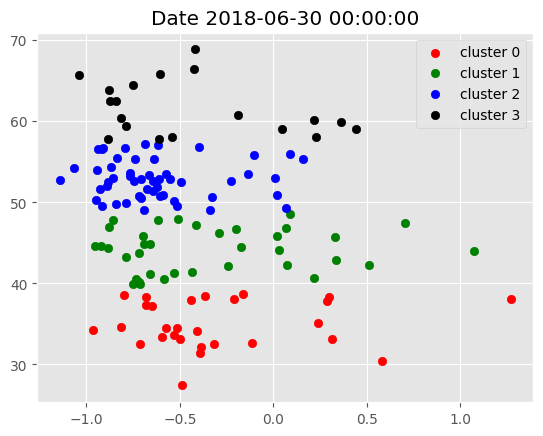

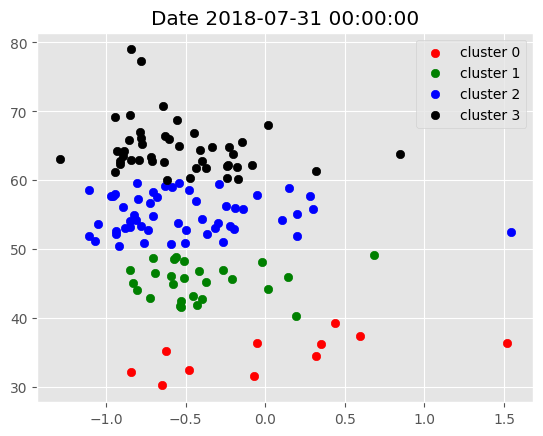

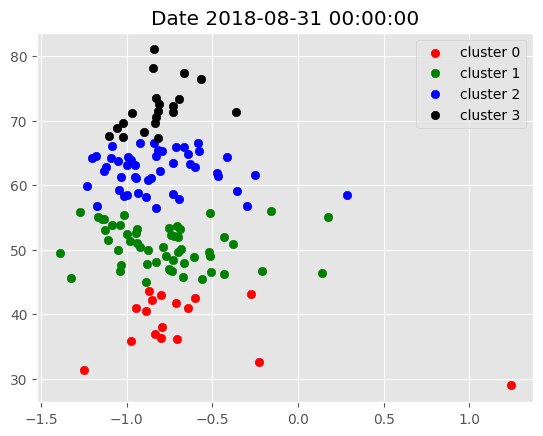

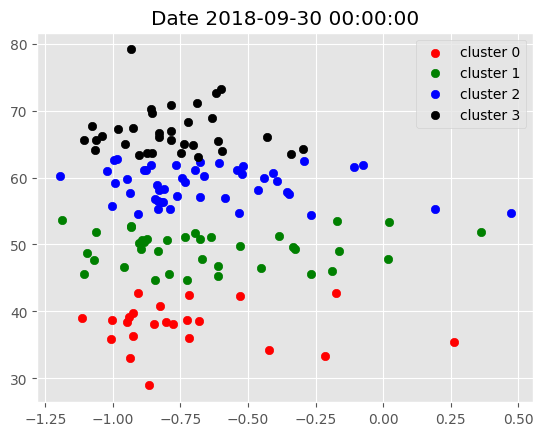

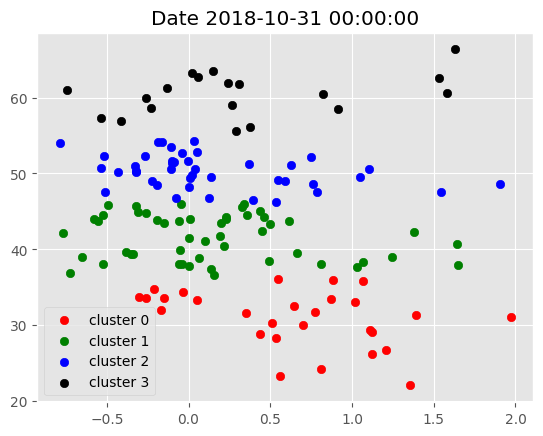

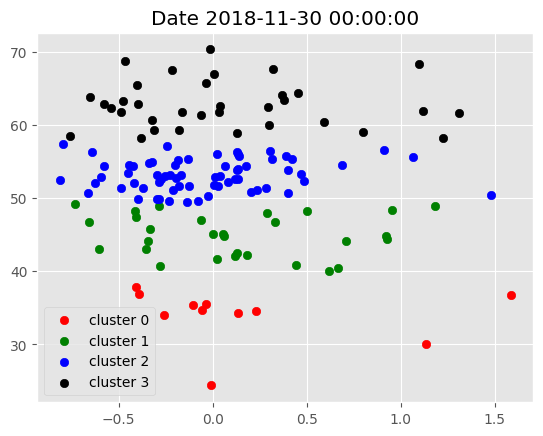

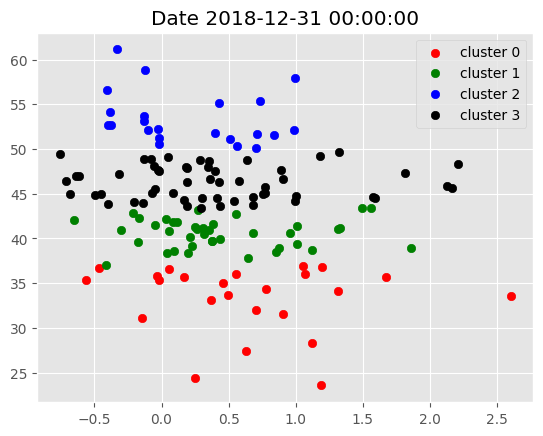

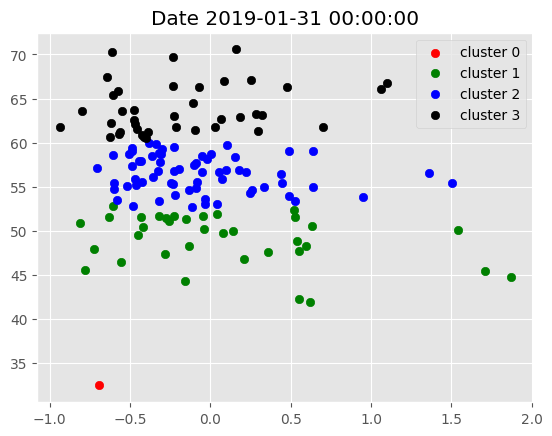

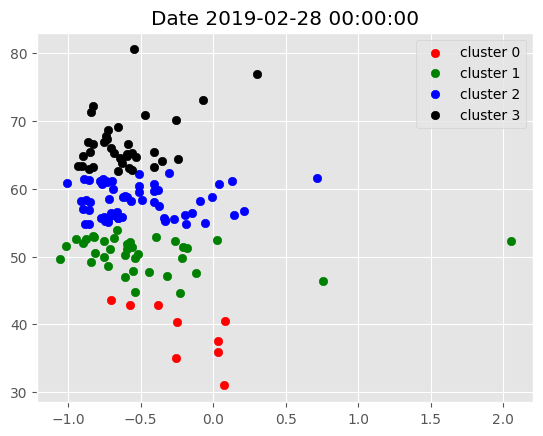

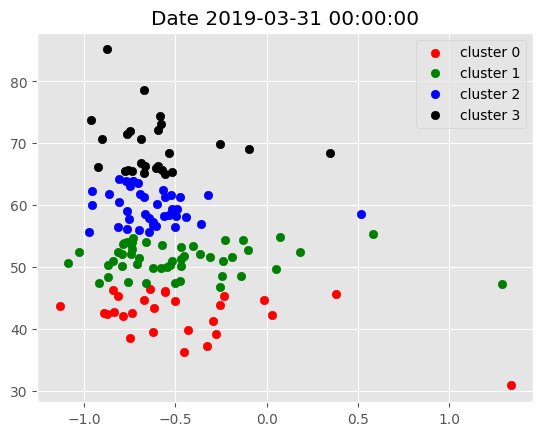

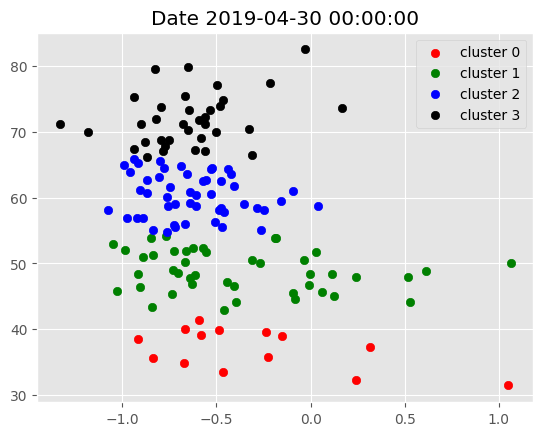

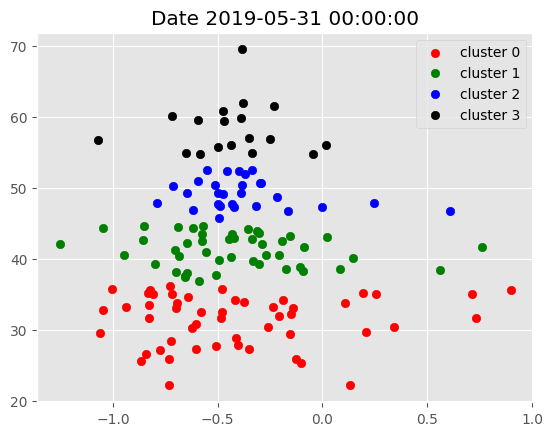

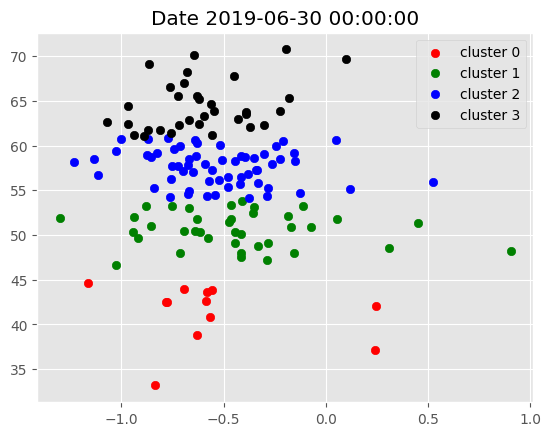

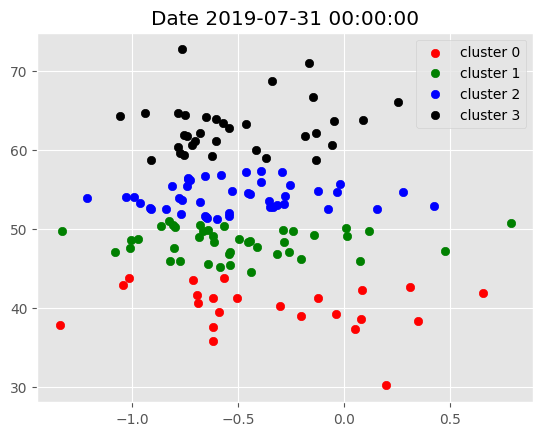

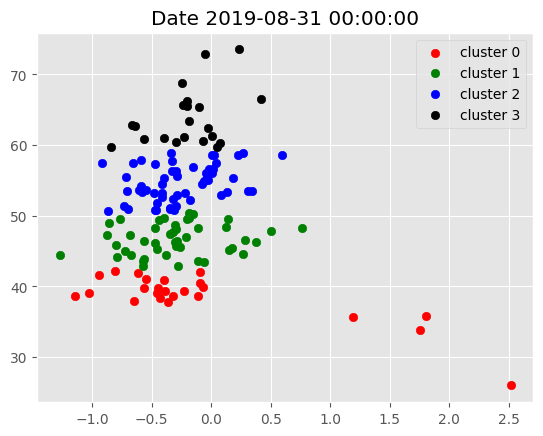

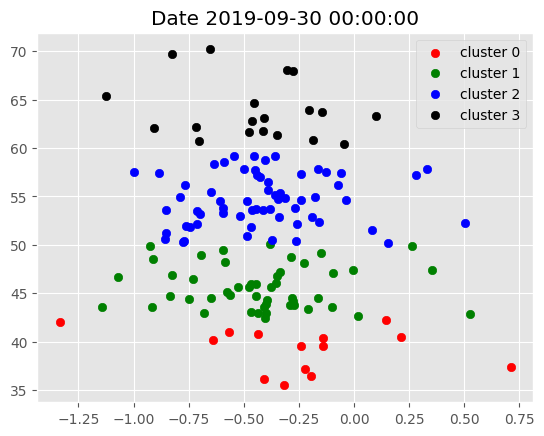

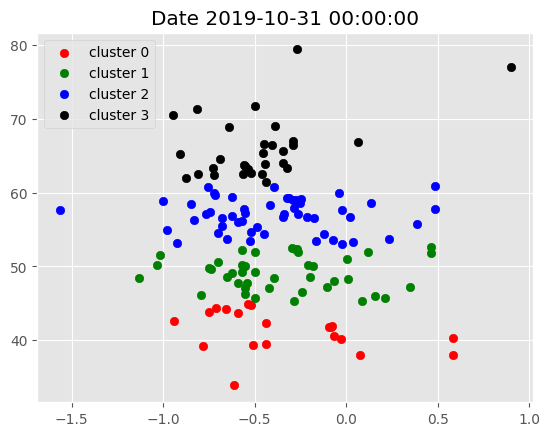

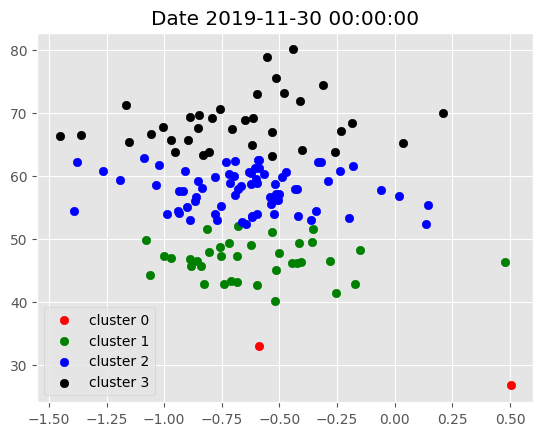

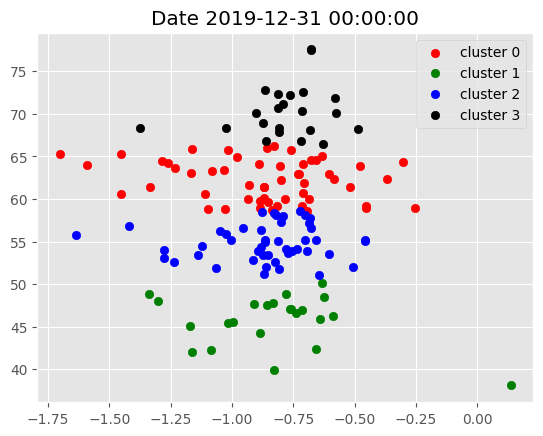

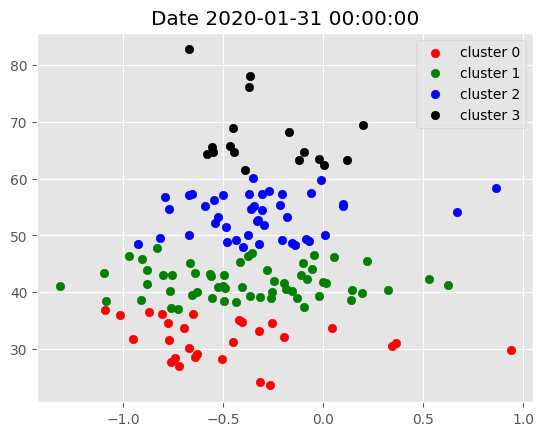

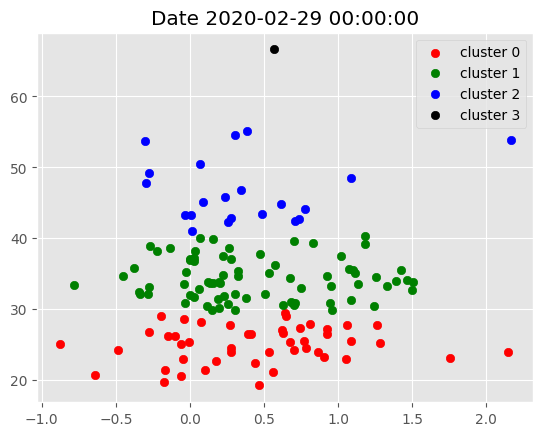

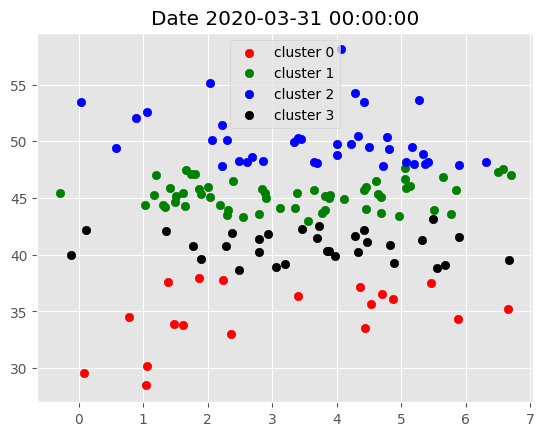

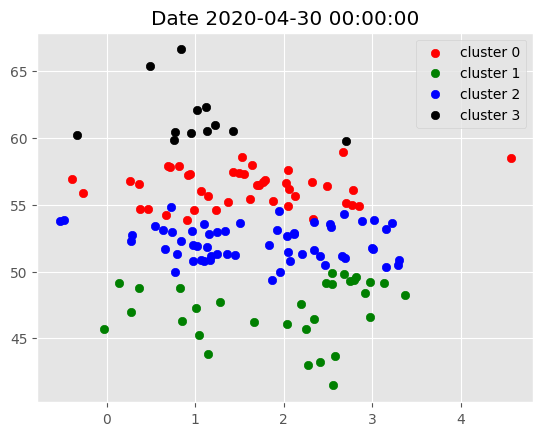

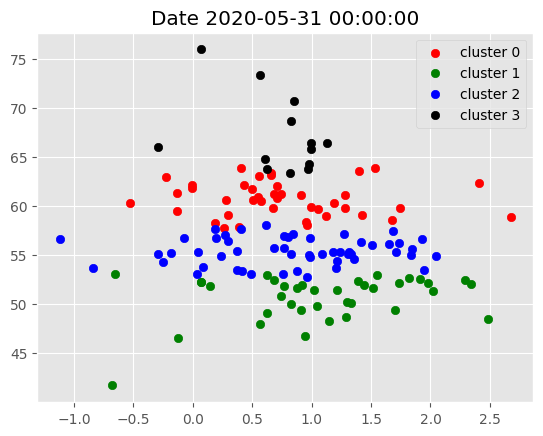

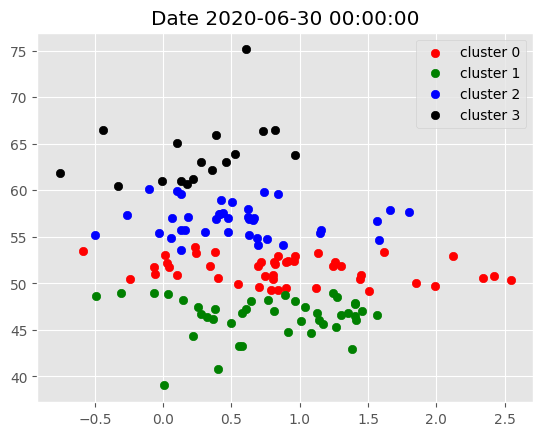

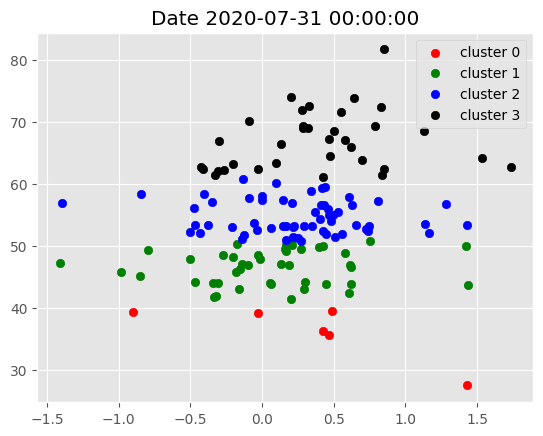

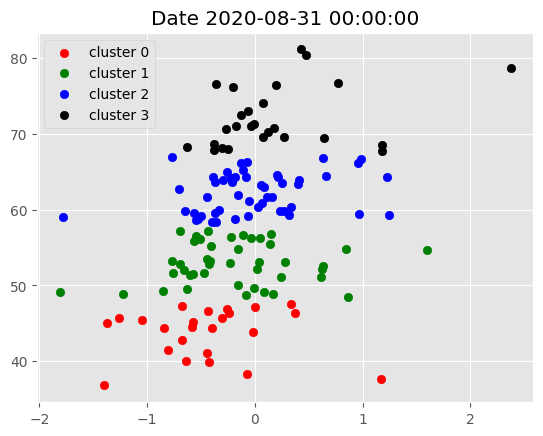

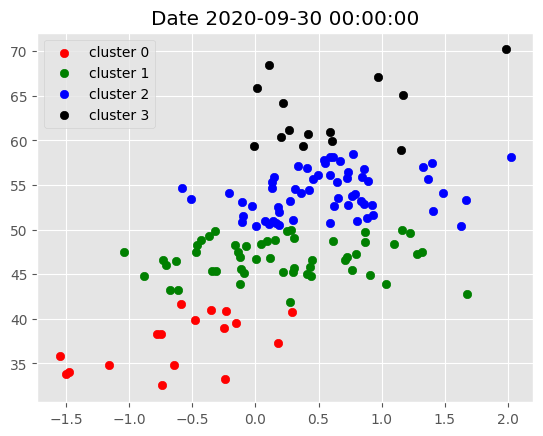

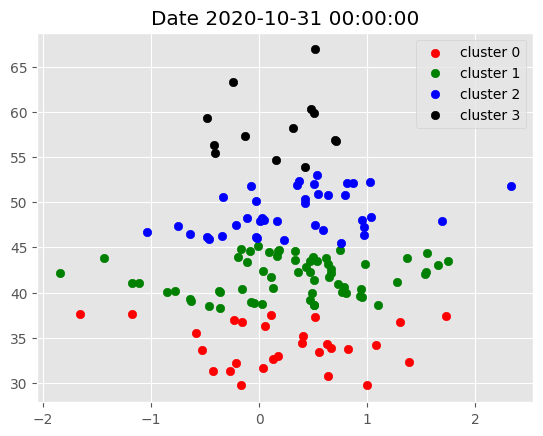

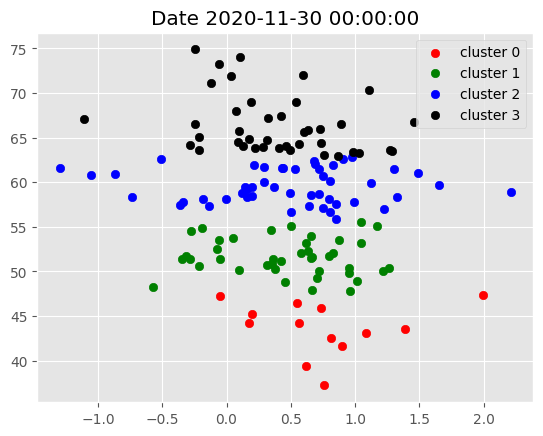

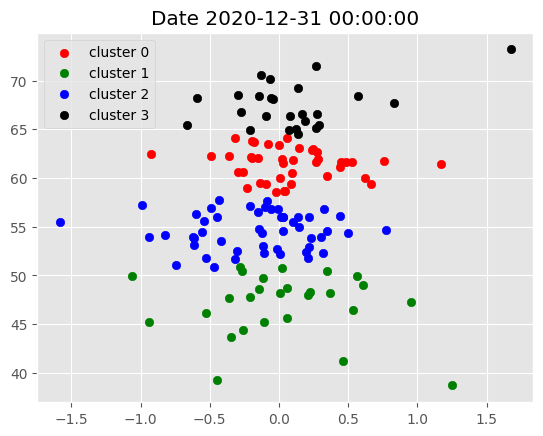

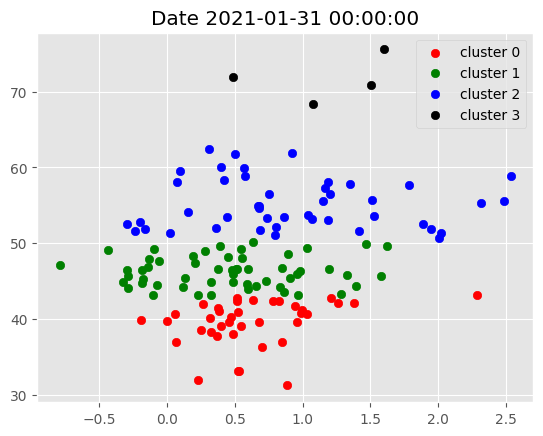

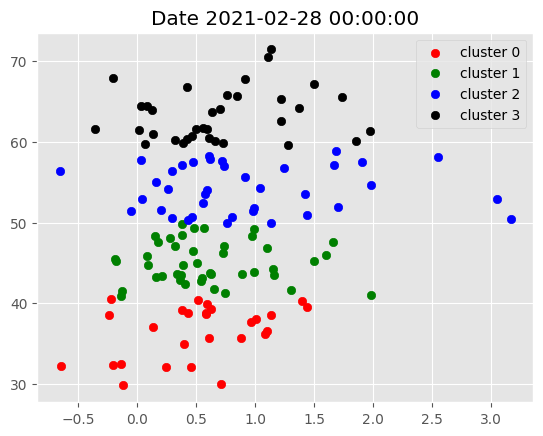

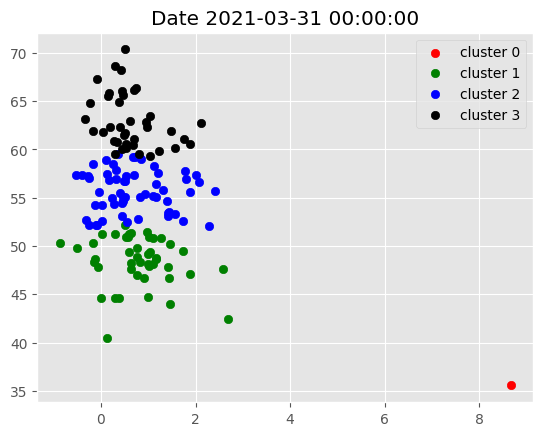

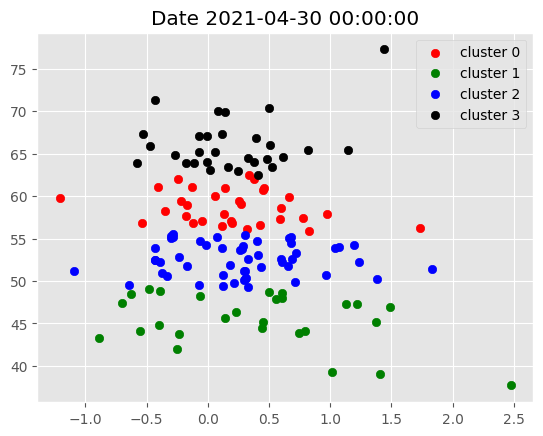

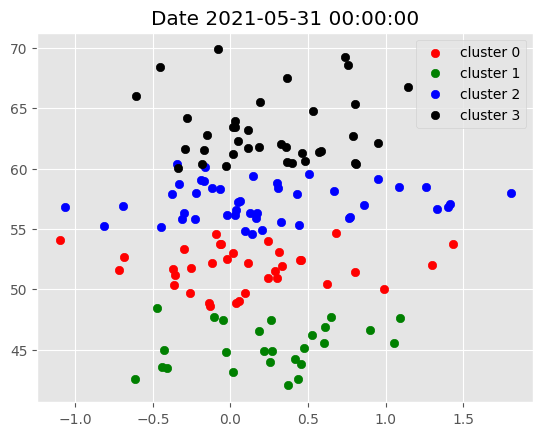

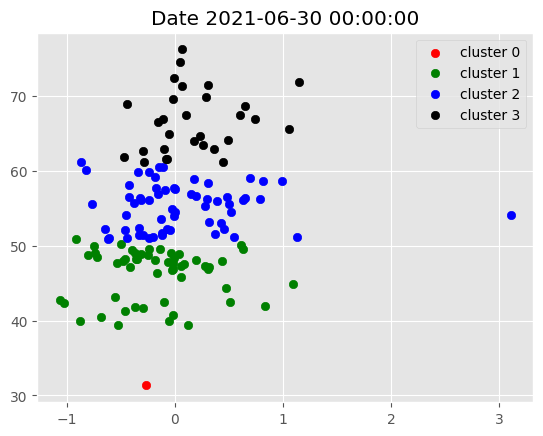

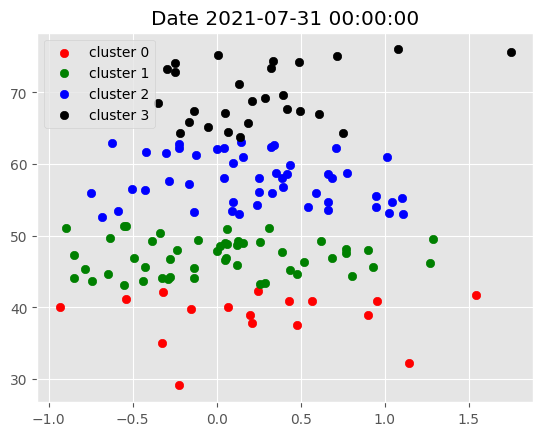

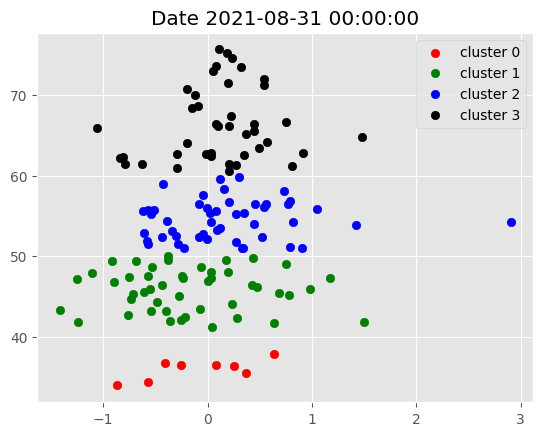

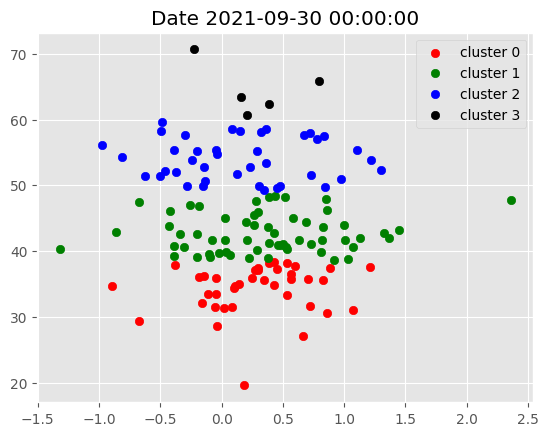

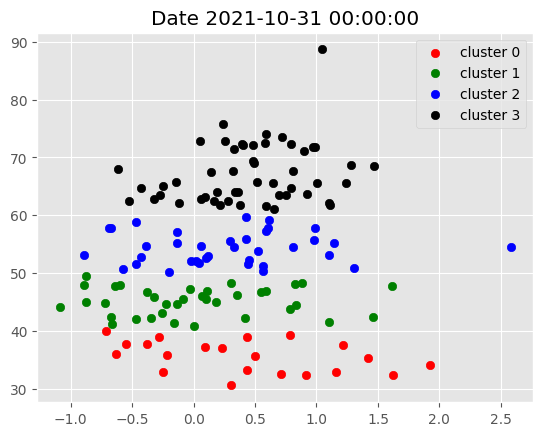

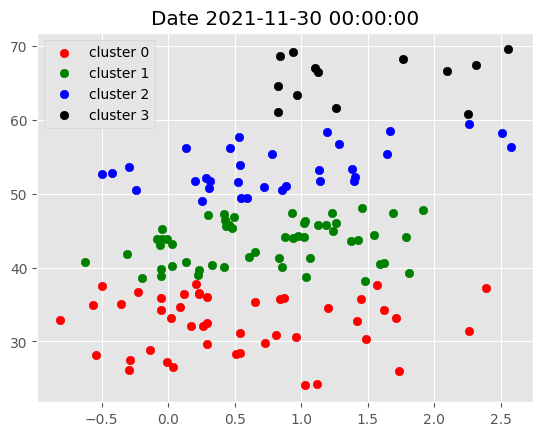

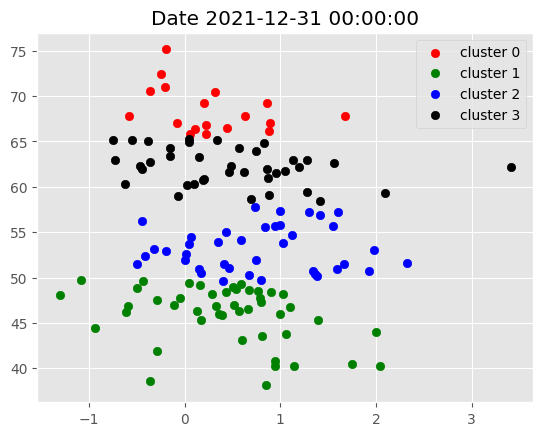

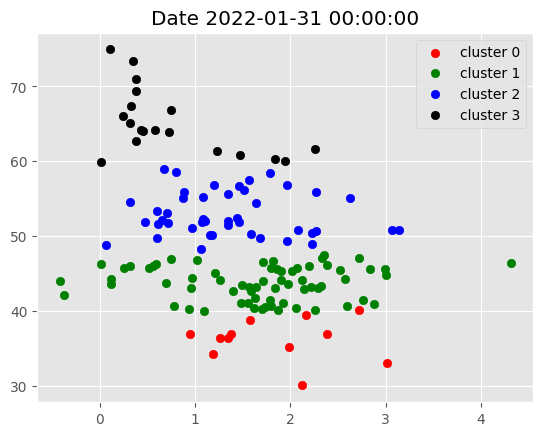

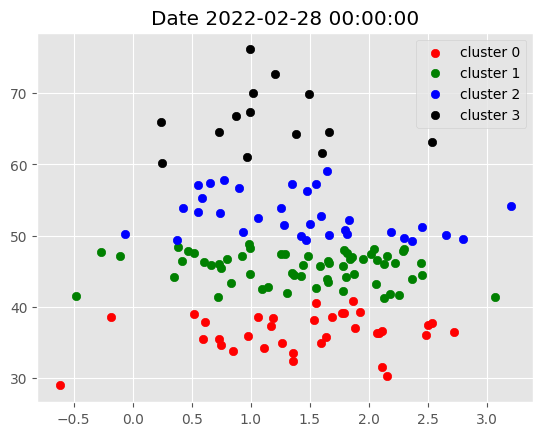

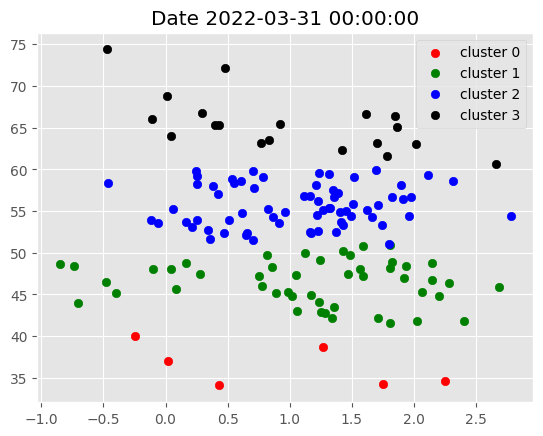

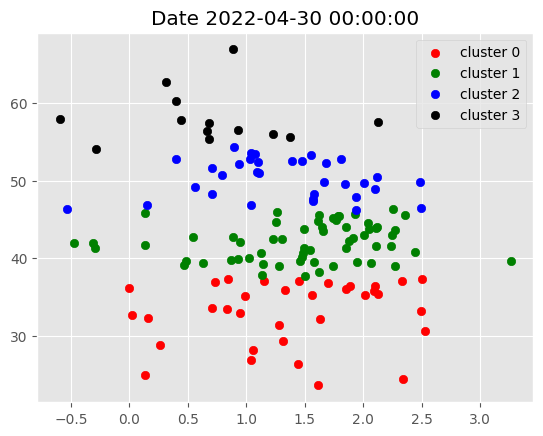

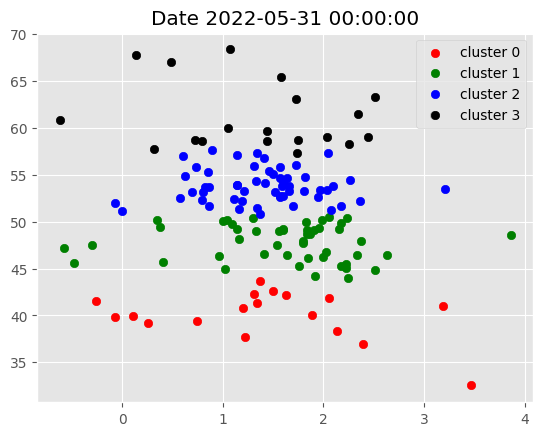

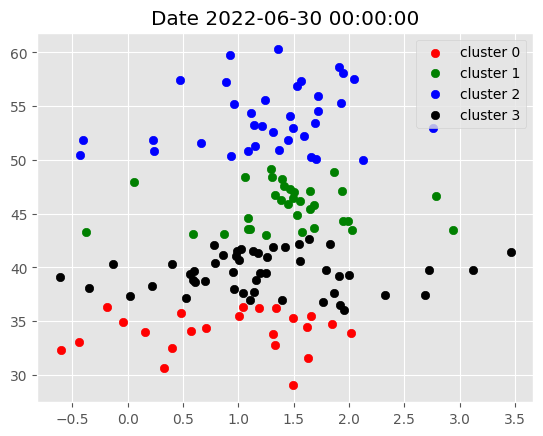

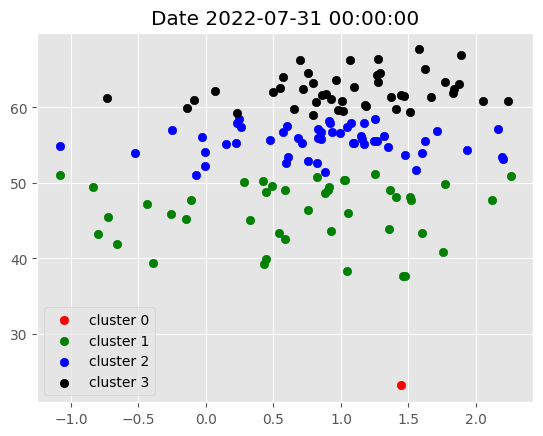

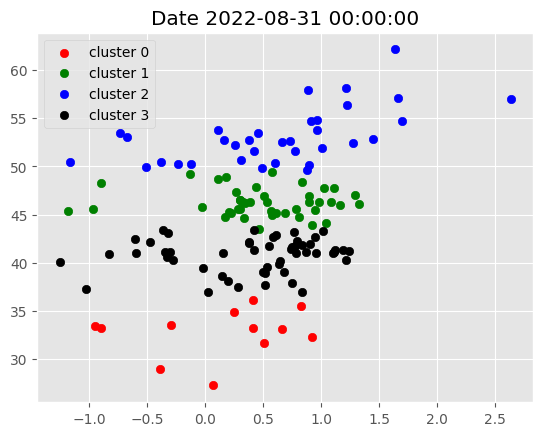

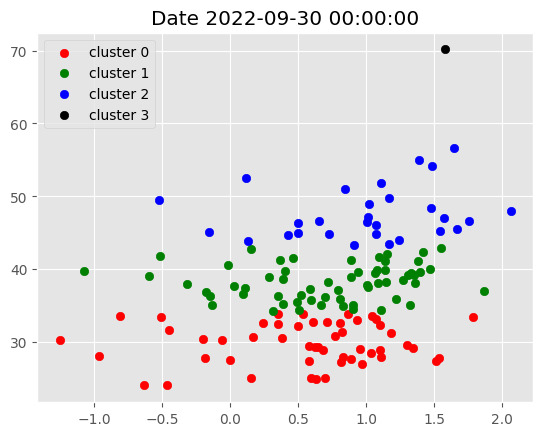

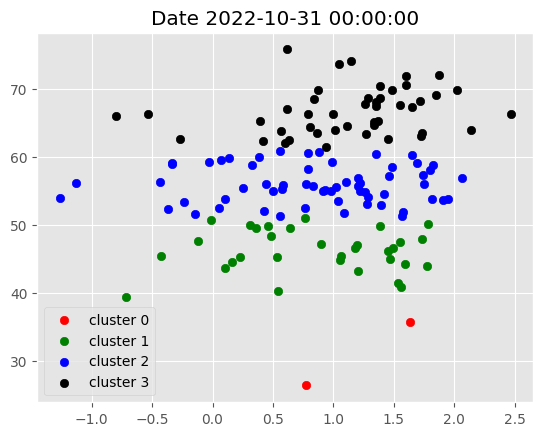

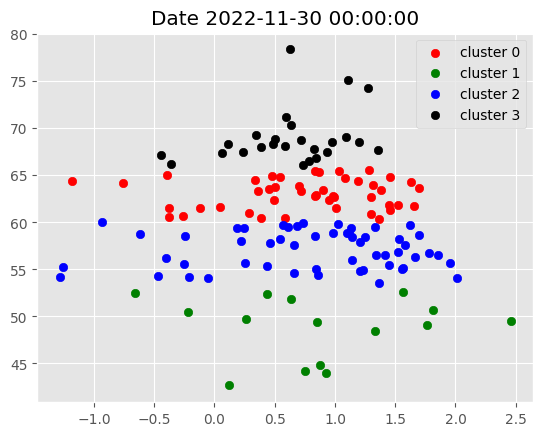

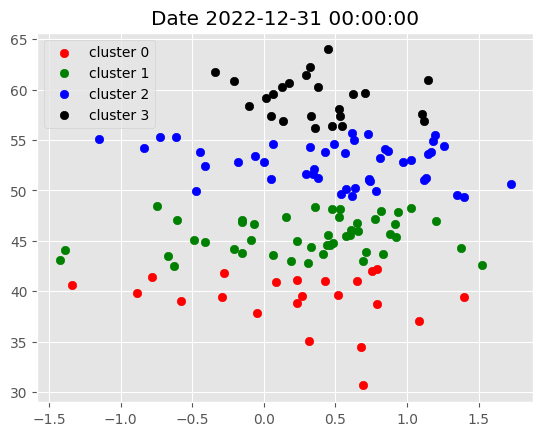

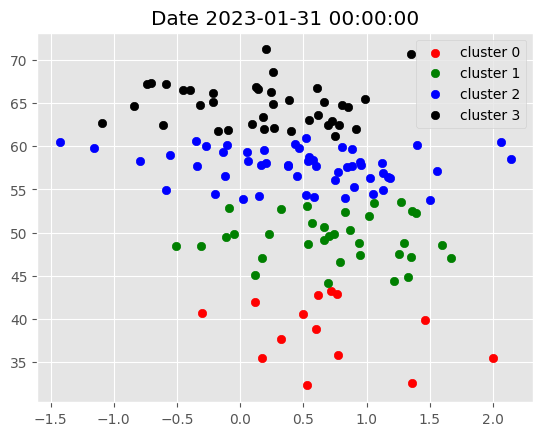

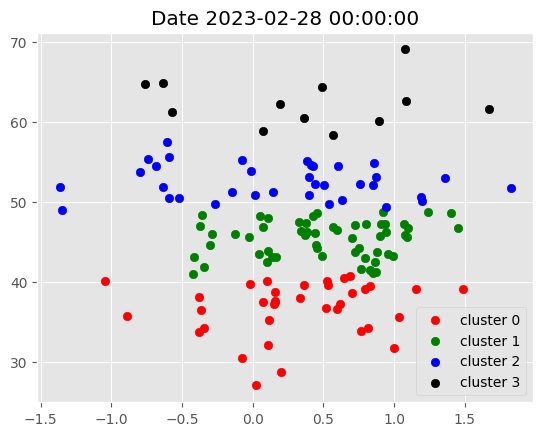

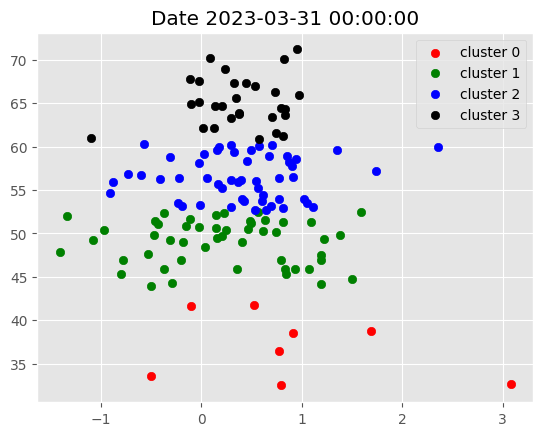

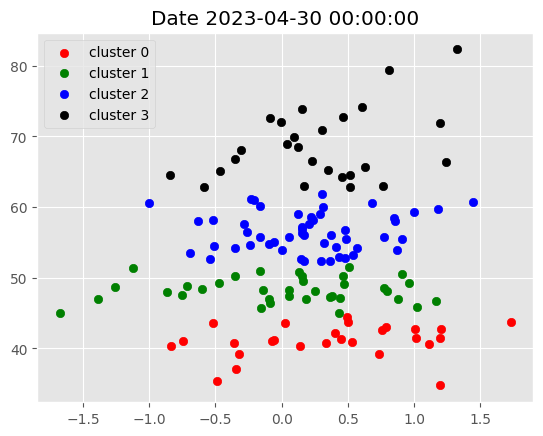

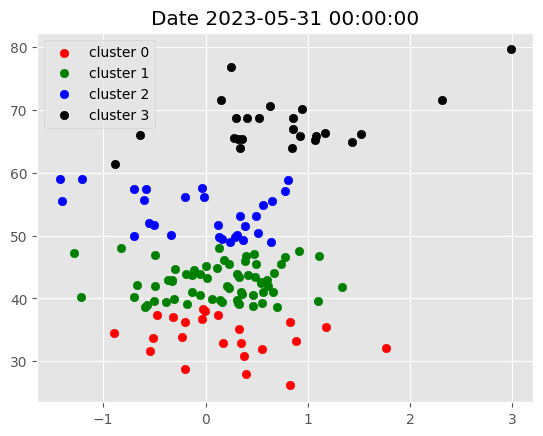

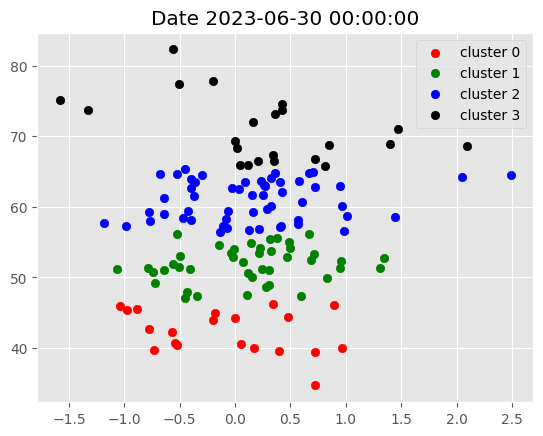

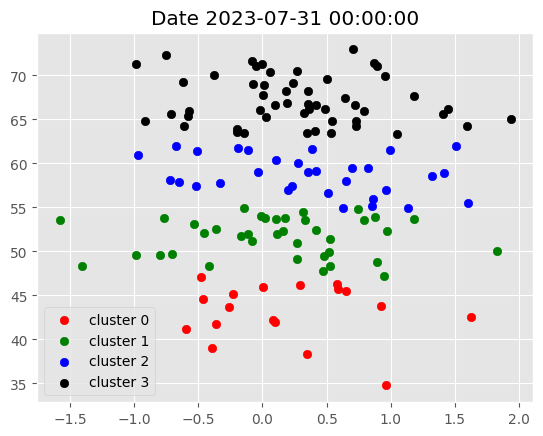

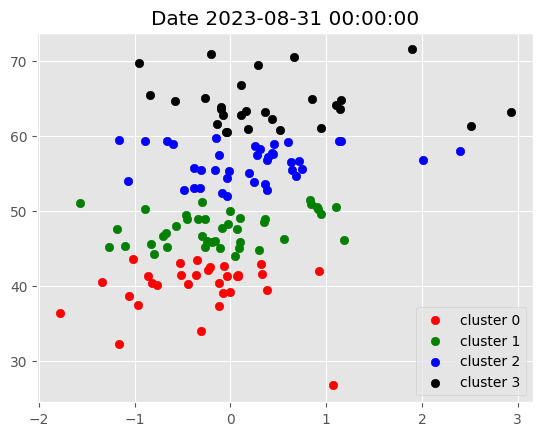

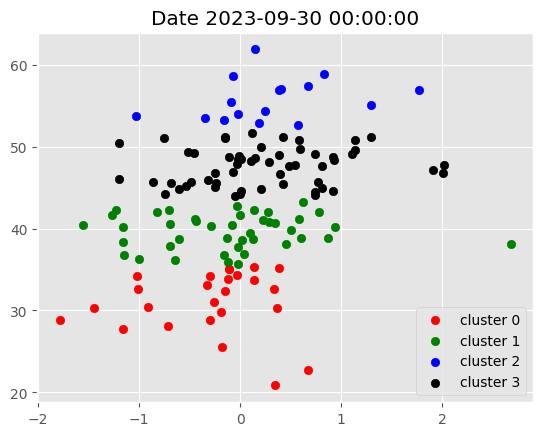

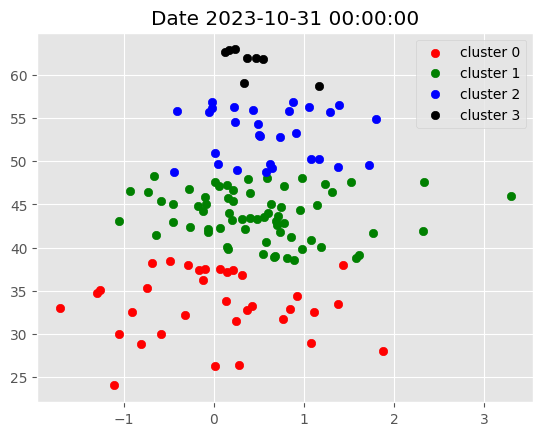

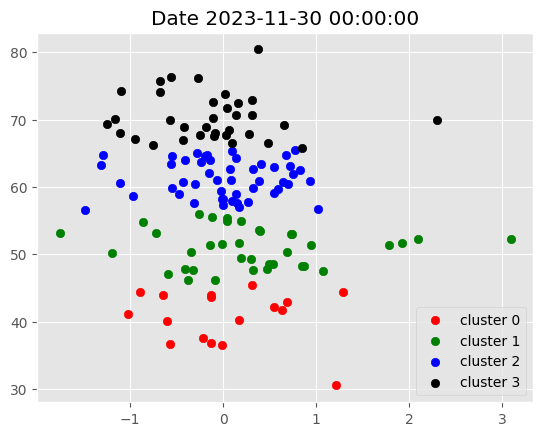

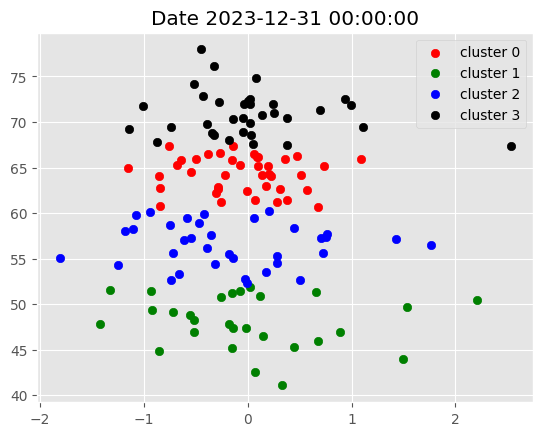

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [16]:
# Portfolio based on Efficient Frontier max sharpe ratio optimization
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',


## Portfolio optimization function

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                      frequency = 252)
    cov = risk_models.sample_cov(prices = prices,
                                 frequency = 252)
    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound, .1),
                           solver = 'SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

ModuleNotFoundError: No module named 'pypfopt'